# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

Всю работу можно моделить на несколько шагов:
1. [Предпросмотр данных](#1)
2. [Предобработка данных](#2)
3. [Дополнение таблицы полями для более глубокого анализа](#3)
4. [Исследовательский анализ данных](#4)
5. [Вывод по проекту](#5)

### Шаг  1. Откройте файл с данными и изучите общую информацию. 
## 1

In [59]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
display(data.head())
data.info()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

### Вывод

Была получена таблица с 23699 записями и 22 полями. 
Типы полей: bool(2), float64(14), int64(3), object(3).
Сразу можно сказать, что в некоторых полях имеются пропущенные значения, которые нужно заменить подходящими, либо избавиться от некоректных данных.

### Шаг 2. Предобработка данных
## 2

In [60]:
#функция для нахождения полей с пропущенными значениями

def field_nun(data):  
    columns = data.columns
    print('{:<20} {:<}'.format('Поле', 'Количество пропусков'))
    print()
    for i in columns:
        empty_count = data.loc[data[i].isnull()]['first_day_exposition'].count()
        if empty_count != 0:
            print('{:<20} {:<5}'.format(i, empty_count))


field_nun(data)

Поле                 Количество пропусков

ceiling_height       9195 
floors_total         86   
living_area          1903 
is_apartment         20924
kitchen_area         2278 
balcony              11519
locality_name        49   
airports_nearest     5542 
cityCenters_nearest  5519 
parks_around3000     5518 
parks_nearest        15620
ponds_around3000     5518 
ponds_nearest        14589
days_exposition      3181 


In [61]:
#обработка пропусков и некорректных значений в поле floors_total
data.loc[data['floors_total'].isnull(), 'floors_total'] = data['floor']

#обработка пропусков и некорректных значений в поле living_area
living_area_persents = data['living_area'].mean() / data['total_area'].mean()
data.loc[data['living_area'].isnull(), 'living_area'] = data['total_area'] * living_area_persents

#обработка пропусков и некорректных значений в поле is_apartment
data.loc[data['is_apartment'].isnull(), 'is_apartment'] = False

#обработка пропусков и некорректных значений в поле kitchen_area
kitchen_area_persents = data['kitchen_area'].mean() / data['total_area'].mean()
data.loc[data['kitchen_area'].isnull(), 'kitchen_area'] = data['total_area'] * living_area_persents

#обработка пропусков и некорректных значений в поле balcony
data.loc[data['balcony'].isnull(), 'balcony'] = 0

#обработка пропусков и некорректных значений в поле locality_name
data.dropna(subset = ['locality_name'], inplace = True)

#обработка пропусков и некорректных значений в поле parks_around3000
data.loc[data['parks_around3000'].isnull(), 'parks_around3000'] = 0

#обработка пропусков и некорректных значений в поле ponds_around3000
data.loc[data['ponds_around3000'].isnull(), 'ponds_around3000'] = 0

#обработка пропусков и некорректных значений в поле cityCenters_nearest для Питера отдельно и для остальный н.п.
data.loc[(data['cityCenters_nearest'].isnull()) & (data['locality_name'] == 'Санкт-Петербург'), 'cityCenters_nearest'] = \
            data.loc[data['locality_name'] == 'Санкт-Петербург']['cityCenters_nearest'].mean()
data.loc[(data['cityCenters_nearest'].isnull()) & (data['locality_name'] != 'Санкт-Петербург'), 'cityCenters_nearest'] = \
            data.loc[data['locality_name'] != 'Санкт-Петербург']['cityCenters_nearest'].mean()
#display(data.loc[(data['cityCenters_nearest'].isnull()) & (data['locality_name'] == 'Санкт-Петербург')])
field_nun(data)

Поле                 Количество пропусков

ceiling_height       9160 
airports_nearest     5534 
parks_nearest        15586
ponds_nearest        14565
days_exposition      3180 


In [62]:
# удаление дубликатов
print(data.duplicated().sum())
data = data.drop_duplicates().reset_index(drop = True)
print(data.duplicated().sum())

0
0


In [63]:
#изменение типов некоторых полей

#список с полями, которые приводятся к int
float_types_list = ['total_area', 'living_area', 'kitchen_area', 'total_images', 'rooms', 'floor', 'floors_total', 'balcony',
                    'last_price', 'parks_around3000', 'ponds_around3000', 'cityCenters_nearest']

#функция, которая огругляет значение до целого, а потом приводит к int
for i in float_types_list:   
    round(data[i])
    data[i] = data[i].astype('int', errors = 'ignore')


data['ceiling_height'] = round(data['ceiling_height'], 2)    
print(data.dtypes)


total_images              int64
last_price                int64
total_area                int64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total              int64
living_area               int64
floor                     int64
is_apartment               bool
studio                     bool
open_plan                  bool
kitchen_area              int64
balcony                   int64
locality_name            object
airports_nearest        float64
cityCenters_nearest       int64
parks_around3000          int64
parks_nearest           float64
ponds_around3000          int64
ponds_nearest           float64
days_exposition         float64
dtype: object


### Вывод

Для поиска полей с пропущенными значениями была использована функция field_nun. Полсле этого в поле ceiling_height некоректные данные были заменены на медиану, а пропущенные на среднее по полю, так как не было анамально больших значений. Если в поле floors_total отсутсвовали значения, то их заменили на фактическое значение этажа квартиры. В поле living_area пропуски заменили на значение total_area * (среднее по полю living_area / среднее по полю total_area), так как это значение не будет аномальным, будет даже типичным для поля, аналогично и поле kitchen_area. Пропуски в поле is_apartment заменили на False, это не явный пропуск(если значение не True, то его не указали). Пропуск в поле balcony связан с отсутствием балкона, НаН заменили на 0, аналогично parks_around3000 и ponds_around3000(парки и и пруды в радиусе 3 км). Записи, где отсутствовала локация квартиры, то есть пустые значения в поле  locality_name, были удалены, так как местоположение квартиры - это главный критерий для выбора и заменить эти пропуски по предположению на что-то другое нельзя. В поле cityCenters_nearest пропуски были заменены отдельно для питера и отдельно для остальных городов на среднее по полю. Кроме этого были удалены полные дубликаты и у некоторых полей были изменены типы с float на int. В поле  ceiling_height пропуски были оставлены, ибо их слишком много.

Пропуски в полях airports_nearest, parks_nearest были оставлены, так как эти данные не понадобятся в исследлвании. А НаНы в ponds_nearest не изменены на подходящие значения, ибо они говорят, что квартира в данный момент ещё не куплена.

### Шаг 3. Посчитайте и добавьте в таблицу
## 3

In [64]:
#добавление поля kvm_price с данными о стоимости 1 квадратного метра
data['kvm_price'] = (round(data['last_price'] / data['total_area']))

#добавление поля date_exposition, которое содержит только дату из поля first_day_exposition
data['date_exposition'] = pd.DatetimeIndex(data['first_day_exposition']).date

#добавление поля ratio_living_total, которое содержит соотношение жилой площади к общей
data['ratio_living_total'] = round(data['living_area'] / data['total_area'] * 100, 2)

#добавление поля ratio_kitchen_total, которое содержит соотношение площади кухни к общей
data['ratio_kitchen_total'] = round(data['kitchen_area'] / data['total_area'] * 100, 2)

#функция для категоризации данных по этажу 
def floor_func(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

data['floor_group'] = data.apply(floor_func, axis = 1)

### Вывод

Для удобства расчетов и анализа быди добавлены 5 полей. Поле kvm_price с данными о стоимости 1 квадратного метра, поле date_exposition, которое содержит только дату из поля first_day_exposition, поле ratio_living_total, которое содержит соотношение жилой площади к общей, поле ratio_kitchen_total, которое содержит соотношение площади кухни к общей и поле floor_group для категоризации данных о этажу квартиры.

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:
## 4
### Гистограммы для площадь, цена, число комнат, высота потолков.

Средняя площадь 60.10093023255814
Средняя цена 6541126.897928119
Медианное количество комнат 2.0
Средняя высота потолков 2.7712870945479637


,ceiling_height,last_price,rooms,total_area
ceiling_height,1.000000,0.329087,0.183125,0.392896
last_price,0.329087,1.000000,0.305026,0.683100
rooms,0.183125,0.305026,1.000000,0.717106
total_area,0.392896,0.683100,0.717106,1.000000


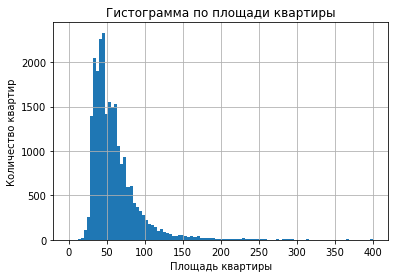

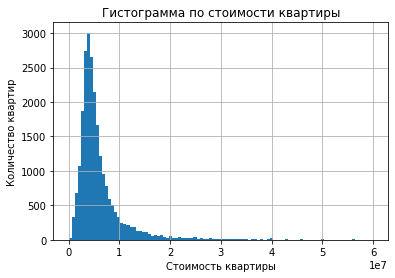

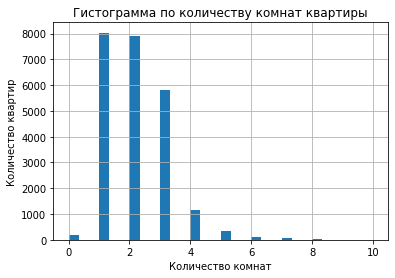

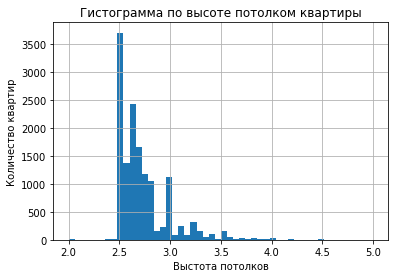

In [65]:
#гистограммы по total_area, last_price, rooms, ceiling_height
data.hist('total_area', bins = 100, range = (0, 400))
plt.title('Гистограмма по площади квартиры')
plt.xlabel('Площадь квартиры')
plt.ylabel('Количество квартир')


data.hist('last_price', bins = 100, range = (0, 60000000))
plt.title('Гистограмма по стоимости квартиры')
plt.xlabel('Стоимость квартиры')
plt.ylabel('Количество квартир')

data.hist('rooms', bins = 30, range = (0, 10))
plt.title('Гистограмма по количеству комнат квартиры')
plt.xlabel('Количество комнат')
plt.ylabel('Количество квартир')

ceiling_h_data  = data.query('ceiling_height != "NaN"')
ceiling_h_data.hist('ceiling_height', bins = 50, range = (2, 5))
plt.title('Гистограмма по высоте потолком квартиры')
plt.xlabel('Выстота потолков')
plt.ylabel('Количество квартир')


#расчет средних и медианных значений для  total_area, last_price, rooms, ceiling_height
print('Средняя площадь', data['total_area'].mean())
print('Средняя цена', data['last_price'].mean())
print('Медианное количество комнат', data['rooms'].median())
print('Средняя высота потолков', ceiling_h_data['ceiling_height'].mean())

#сводная таблица для просмотра корреляции total_area, last_price, rooms, ceiling_height
data_ta_lp_r_ch = data.pivot_table(index = 'date_exposition',  \
                                   values = ['total_area', 'last_price', 'rooms', 'ceiling_height'], aggfunc = 'median')
display(data_ta_lp_r_ch.corr())

По полученным гистограммам можно сделать вывод, что чаще всего встречаются квартиры с лощадью в районе 40 - 50 кв.м., а квартиры от 100 кв.м. можно назвать достаточно редкими. По цене можно сказать, что в чаще всего встречаются на рынке квартиры со стоймостью +-5 млн.. Популярнее всего 1-2-3-комнтаные квартиры, а высота потолков чаще всего не привышает 3 метров.
Кроме этого, мы видим положительный коэфициент корреляции для всех велечин. Например, М=мы можем спокойно связать стоимость квартиры с её площадью(к = +- 0.7), а площадь с количеством комнат.

### Изучение времени продажи квартир

days_exposition
Среднее 180.7531998045921 --------- Медиана 95.0
count    20470.000000
mean       180.753200
std        219.777916
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64


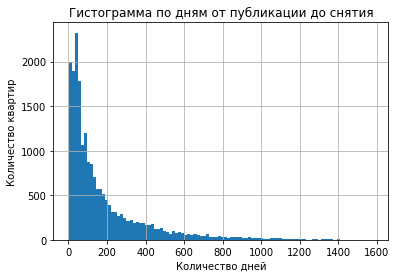

In [66]:
#получение среднего и медианы по полю days_exposition
good_date_data = data.query('days_exposition != "NaN"')
days_exposition_mean = good_date_data['days_exposition'].mean()
days_exposition_median = good_date_data['days_exposition'].median()
print('days_exposition')
print('Среднее {} --------- Медиана {}'.format(days_exposition_mean, days_exposition_median))

#вывод гистограммы по days_exposition
good_date_data.hist('days_exposition', bins = 100)
plt.title('Гистограмма по дням от публикации до снятия')
plt.xlabel('Количество дней')
plt.ylabel('Количество квартир')

print(good_date_data['days_exposition'].describe())


Из результатов метода describe() можно сказать, что слишком быстрые продажи выделить нельзя, стандартное отклонение больше среднего. А если продажи шли более 400 дней, то их можно назвать очень долгими.

### Чистка от редких значений

In [67]:
#новая таблица с хорошей выборкой данных
good_data = \
good_date_data.query('days_exposition < 400 and total_area <= 200 and last_price <= 20000000 and 2 < ceiling_height < 4.5')

В таблице good_data были собраны значения, которые не являются аномально большими и малыми по следущим полям: days_exposition, total_area, last_price, ceiling_height. Причина избавления от аномальных данных в том, что они слишком велики и влияют на велечины, по которым будет проводиться анализ.

### Изучение факторов влияющих на стоимость квартиры

Клэфициент корреляции для last_price - rooms: 0.50


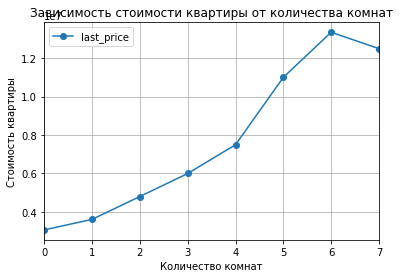

In [68]:
#определение зависимости last_price от rooms
print('Клэфициент корреляции для last_price - rooms: {:.2f}'.format(good_data['last_price'].corr(good_data['rooms'])))
room_good_data = good_data.pivot_table(index = 'rooms', values = 'last_price', aggfunc = 'median')
room_good_data.plot(grid = True, style = 'o-', )
plt.title('Зависимость стоимости квартиры от количества комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Стоимость квартиры')
plt.show()

Исходя из коэфициента корреляции и графика можем сделать вывод, что велечины цены и числа комнат квартиры мвязаны в прямопрпорциональной зависимости. Чем больше комнат, тем дороже квартира.

Клэфициент корреляции для last_price - total_area: 0.7690506682105986


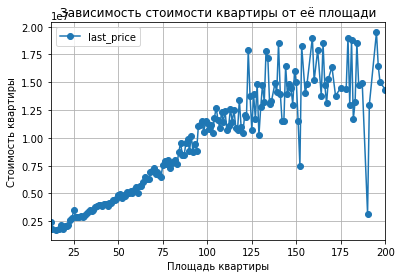

In [69]:
#определение зависимости last_price от total_area
print('Клэфициент корреляции для last_price - total_area:',good_data['last_price'].corr(good_data['total_area']))

area_good_data = good_data.pivot_table(index = 'total_area', values = 'last_price', aggfunc = 'mean')
area_good_data.plot(grid = True, style = 'o-')
plt.title('Зависимость стоимости квартиры от её площади')
plt.xlabel('Площадь квартиры')
plt.ylabel('Стоимость квартиры')

plt.show()

Была получена зависимость, из которой видно, что на рынке большая насыщенность квартир с площадью до 100 кв.м. и ценой до 12 млн.. Видна зависимость, что с ростом площади растет и стоимость.

Клэфициент корреляции для last_price-cityCenters_nearest: -0.48537474835883926


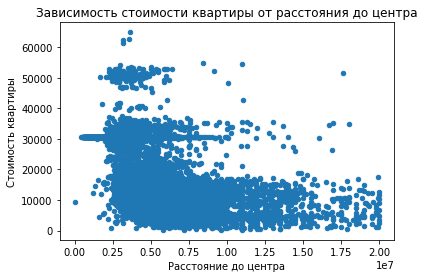

In [70]:
#определение зависимости last_price от cityCenters_nearest
print('Клэфициент корреляции для last_price-cityCenters_nearest:',good_data['last_price'].corr(good_data['cityCenters_nearest']))
good_data[['last_price', 'cityCenters_nearest']].plot(kind = 'scatter', x = 'last_price', y = 'cityCenters_nearest')
plt.title('Зависимость стоимости квартиры от расстояния до центра')
plt.xlabel('Расстояние до центра')
plt.ylabel('Стоимость квартиры')

plt.show()

На графике стоимость-удаленность от центра видно, что чем ближе квартира к центру, тем она дороже. Коэфициент Пирсона имеет отрицательную велечину.

In [55]:
#определение зависимости last_price от floor_group
floor_good_data = good_data.pivot_table(index = 'floor_group', values = 'last_price', aggfunc = 'median')
print(floor_good_data)

             last_price
floor_group            
другой          4700000
первый          3900000
последний       4300000


Тут получили следующие значения по трем категориям: квартиры на первом этаже самые дешевые, квартиры на последнем этаже чуть дороже, самыми дорогими квартирами оказались те, которые находяться в середине.

In [71]:
#добавление полей с годом, месяцем и днем недели публикации объявления
good_data['date_exposition'] = pd.to_datetime(good_data['date_exposition'])
good_data['weekday'] = good_data['date_exposition'].dt.weekday
good_data['month'] = good_data['date_exposition'].dt.month
good_data['year'] = good_data['date_exposition'].dt.year

print('Клэфициент корреляции для last_price-weekday:',good_data['last_price'].corr(good_data['weekday']))
print('Клэфициент корреляции для last_price-month:',good_data['last_price'].corr(good_data['month']))
print('Клэфициент корреляции для last_price-year:',good_data['last_price'].corr(good_data['year']))

Клэфициент корреляции для last_price-weekday: -0.01339154635668726
Клэфициент корреляции для last_price-month: 0.009767756099596884
Клэфициент корреляции для last_price-year: -0.02499151400662148


Из коэфициентов Пирсона видим, что велечины никак не связаны.

In [73]:
#таблица топ 10 поплярных городов сервиса Яндекс.Недвижимость
top_10_towns = good_data.pivot_table(index = 'locality_name', values = 'kvm_price', aggfunc = ['mean', 'count'])
top_10_towns.columns = ['mean_price', 'count']
top_10_towns = top_10_towns.sort_values(by = 'count', ascending = False).head(10)
print(top_10_towns)
#определение минимальных и максимальных значений в таблице top_10_towns по полю kvm_price
max_price = top_10_towns['mean_price'].max()
min_price = top_10_towns['mean_price'].min()
print()
print('Город с максимальной ценой кв.м.:')
print(top_10_towns.query('mean_price == @max_price'))
print()
print('Город с минимальной ценой кв.м.:')
print(top_10_towns.query('mean_price == @min_price'))

                      mean_price  count
locality_name                          
Санкт-Петербург    108024.011456   6983
Всеволожск          66827.243386    189
посёлок Мурино      88713.286550    171
посёлок Шушары      79516.124260    169
Колпино             75186.783951    162
Пушкин             100195.044586    157
посёлок Парголово   89897.198198    111
Гатчина             70446.357798    109
деревня Кудрово     91908.761905    105
Петергоф            84095.274510    102

Город с максимальной ценой кв.м.:
                    mean_price  count
locality_name                        
Санкт-Петербург  108024.011456   6983

Город с минимальной ценой кв.м.:
                 mean_price  count
locality_name                     
Всеволожск     66827.243386    189


Были получены города с минимальной и максимальной ценой квадратного метра из списка самых популярных городов сервиса Яндекс.Недвижимость. Питер имеет максимальную стоимость, а Выборг - минимальную.

### Оцениваем расположение квартир относительно центра города

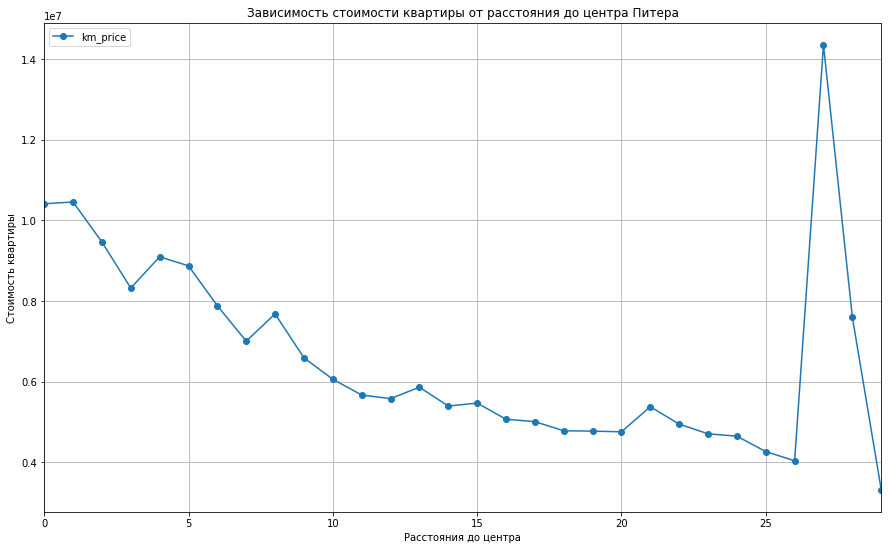

In [74]:
#создаем выборку с условием что город Санкт-Петербург
spb_data = good_data.query('locality_name == "Санкт-Петербург"')

#получаем сводную таблицу, где каждому км от центра соответсвует средняя стоимость квартир в этом км
spb_data['center_km'] = round(spb_data['cityCenters_nearest'] / 1000)
spb_km_price = spb_data.pivot_table(index = 'center_km', values = 'last_price', aggfunc = ['mean', 'count'])
spb_km_price.columns = ['km_price', 'count']

#получаем зависимость отдаленности отцетра и стоимости квартиры
spb_km_price.plot(y = 'km_price', grid = True, style = 'o-', figsize = (15, 9))
plt.title('Зависимость стоимости квартиры от расстояния до центра Питера')
plt.xlabel('Расстояния до центра')
plt.ylabel('Стоимость квартиры')
plt.show()

Можем сделать вывод, что чем дальше квартира от центра, тем она дороже. Большой всплеск в самом конце графика объясняется маленькой выборкой квартир на это км(всего 2). Большой переад в стоимости наблюдается на 7 - 8 км. Делаем вывод радиус центра Питера составляет примерно 7 км.

### Анализ сегмента квартир в центре

Средняя площадь 73.36170212765957
Средняя цена 8599915.180851065
Медианное количество комнат 2.0
Средняя высота потолков 2.8037094220110843


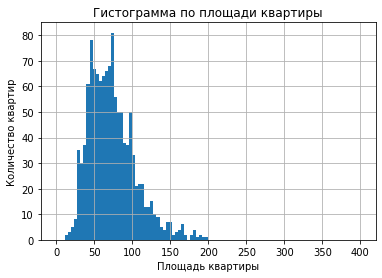

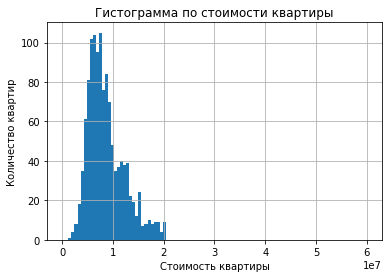

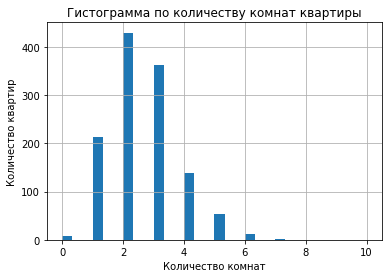

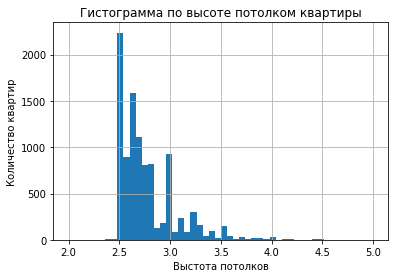

In [75]:
#гистограммы по total_area, last_price, rooms, ceiling_height для Питера
spb_center = spb_data.query('center_km <= 7')
spb_center.hist('total_area', bins = 100, range = (0, 400))
plt.title('Гистограмма по площади квартиры')
plt.xlabel('Площадь квартиры')
plt.ylabel('Количество квартир')

spb_center.hist('last_price', bins = 100, range = (0, 60000000))
plt.title('Гистограмма по стоимости квартиры')
plt.xlabel('Стоимость квартиры')
plt.ylabel('Количество квартир')

spb_center.hist('rooms', bins = 30, range = (0, 10))
plt.title('Гистограмма по количеству комнат квартиры')
plt.xlabel('Количество комнат')
plt.ylabel('Количество квартир')

spb_center_ceiling = ceiling_h_data.query('locality_name == "Санкт-Петербург"')
spb_center_ceiling.hist('ceiling_height', bins = 50, range = (2, 5))
plt.title('Гистограмма по высоте потолком квартиры')
plt.xlabel('Выстота потолков')
plt.ylabel('Количество квартир')


#расчет средних и медианных значений для  total_area, last_price, rooms, ceiling_height
print('Средняя площадь', spb_center['total_area'].mean())
print('Средняя цена', spb_center['last_price'].mean())
print('Медианное количество комнат', spb_center['rooms'].median())
print('Средняя высота потолков', spb_center_ceiling['ceiling_height'].mean())

Из полученных гистограмм сделаем вывод, что в центре квартиры больше, дороже в большинтсве своем, в центре гораздо меньше 1-комнатных квартир, потолки в центральной части города выше.

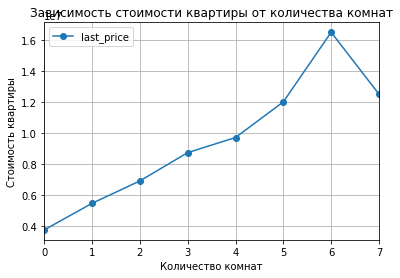

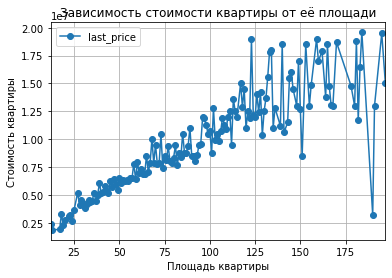

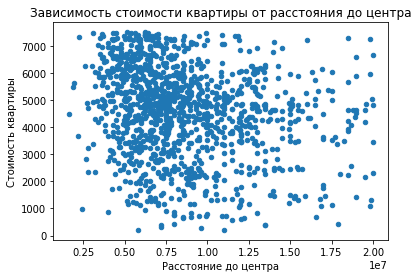

             last_price
floor_group            
другой          8000000
первый          6145000
последний       7800000


In [76]:
#определение зависимости last_price от rooms для Питера
spb_center_room_good_data = spb_center.pivot_table(index = 'rooms', values = 'last_price', aggfunc = 'median')
spb_center_room_good_data.plot(grid = True, style = 'o-')
plt.title('Зависимость стоимости квартиры от количества комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Стоимость квартиры')
plt.show()

#определение зависимости last_price от total_area для Питера
spb_center_area_good_data = spb_center.pivot_table(index = 'total_area', values = 'last_price', aggfunc = 'median')
spb_center_area_good_data.plot(grid = True, style = 'o-')
plt.title('Зависимость стоимости квартиры от её площади')
plt.xlabel('Площадь квартиры')
plt.ylabel('Стоимость квартиры')

#определение зависимости last_price от cityCenters_nearest для Питера
spb_center[['last_price', 'cityCenters_nearest']].plot(kind = 'scatter', x = 'last_price', y = 'cityCenters_nearest')
plt.title('Зависимость стоимости квартиры от расстояния до центра')
plt.xlabel('Расстояние до центра')
plt.ylabel('Стоимость квартиры')
plt.show()

#определение зависимости last_price от floor_group для Питера
spb_center_floor_good_data = spb_center.pivot_table(index = 'floor_group', values = 'last_price', aggfunc = 'median')
print(spb_center_floor_good_data)

По полученным графикам можно сказать, что по сравнению с остальынми записями в таблице, центр Питера дороже в таких показателях как количество комнат, этажа квартиры, площади квартиры.С удаленностью от центра стоимость снижается.

### Шаг 5. Общий вывод
## 5

### Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод info())
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  посчитано и добавлено в таблицу: цена квадратного метра
- [x]  посчитано и добавлено в таблицу: день недели, месяц и год публикации объявления
- [x]  посчитано и добавлено в таблицу: этаж квартиры; варианты — первый, последний, другой
- [x]  посчитано и добавлено в таблицу: соотношение жилой и общей площади, а также отношение площади кухни к общей
- [x]  изучены следующие параметры: площадь, цена, число комнат, высота потолков
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?"
- [x]  выполнено задание: "Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили."
- [x]  выполнено задание: "Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года. "Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце '*locality_name'*. "
- [x]  выполнено задание: "Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (*'locality_name'*). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона. "
- [x]  выполнено задание: "Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?"
- [x]  в каждом этапе есть выводы
- [x]  есть общий вывод